In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [4]:
folder_path = '/content/drive/My Drive/archive-2'


In [5]:
import os

# Path to your folder
folder_path = '/content/drive/My Drive/archive-2'

# List all files in the folder
for file in os.listdir(folder_path):
    print(file)


eurusd_hour.csv
eurusd_minute.csv
eurusd_news.csv
Untitled.ipynb


In [6]:
# Paths to the files
hour_csv_path = '/content/drive/My Drive/archive-2/eurusd_hour.csv'
minute_csv_path = '/content/drive/My Drive/archive-2/eurusd_minute.csv'
news_csv_path = '/content/drive/My Drive/archive-2/eurusd_news.csv'


In [7]:
 import pandas as pd

# Example of reading the 'eurusd_hour.csv' file
df = pd.read_csv(hour_csv_path)
print(df.head())


         Date   Time      BO      BH      BL      BC     BCh      AO      AH  \
0  2005-05-02  00:00  1.2852  1.2852  1.2840  1.2844 -0.0008  1.2854  1.2854   
1  2005-05-02  01:00  1.2844  1.2848  1.2839  1.2842 -0.0002  1.2846  1.2850   
2  2005-05-02  02:00  1.2843  1.2854  1.2841  1.2851  0.0008  1.2845  1.2856   
3  2005-05-02  03:00  1.2851  1.2859  1.2850  1.2851  0.0000  1.2853  1.2861   
4  2005-05-02  04:00  1.2852  1.2859  1.2849  1.2855  0.0003  1.2854  1.2861   

       AL      AC     ACh  
0  1.2842  1.2846 -0.0008  
1  1.2841  1.2844 -0.0002  
2  1.2843  1.2853  0.0008  
3  1.2852  1.2853  0.0000  
4  1.2851  1.2857  0.0003  


In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from google.colab import drive



# Load dataset from Google Drive
# Update the file path below to match the location of 'eurusd_hour.csv' in your Google Drive
file_path = '/content/drive/My Drive/archive-2/eurusd_hour.csv'
data = pd.read_csv(file_path)

# Assuming we will use the 'BC' (Bid Close) column for the prediction
values = data['BC'].values.reshape(-1, 1)

# Normalize features with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Convert series to supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Concatenate all columns
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Define the number of lag hours
n_hours = 3  # Number of lag hours
n_features = 1  # Number of features (using only 'BC' column here)

# Frame as supervised learning
reframed = series_to_supervised(scaled_values, n_hours, 1)

# Split into train and test sets
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# The shapes of the input data
train_X.shape, train_y.shape, test_X.shape, test_y.shape


((65156, 3, 1), (65156,), (27925, 3, 1), (27925,))

In [13]:
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense


model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')



# Save the model
model.save('/content/drive/My Drive/my_lstm_model.h5')

# Save the scaler
import joblib
scaler_filename = "/content/drive/My Drive/my_lstm_scaler.save"
joblib.dump(scaler, scaler_filename)


# Model summary to show the architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Define the number of epochs and batch size
epochs = 10  # This is a starting point, you might need to adjust based on your data
batch_size = 32  # Smaller batch sizes can improve generalization

# Train the model
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/10
2037/2037 - 9s - loss: 3.7260e-04 - val_loss: 1.4762e-04 - 9s/epoch - 5ms/step
Epoch 2/10
2037/2037 - 9s - loss: 5.6014e-05 - val_loss: 2.1224e-04 - 9s/epoch - 5ms/step
Epoch 3/10
2037/2037 - 7s - loss: 5.6717e-05 - val_loss: 1.8608e-04 - 7s/epoch - 3ms/step
Epoch 4/10
2037/2037 - 9s - loss: 5.4391e-05 - val_loss: 1.5812e-04 - 9s/epoch - 4ms/step
Epoch 5/10
2037/2037 - 7s - loss: 4.6295e-05 - val_loss: 1.4380e-04 - 7s/epoch - 3ms/step
Epoch 6/10
2037/2037 - 8s - loss: 4.3082e-05 - val_loss: 1.9890e-04 - 8s/epoch - 4ms/step
Epoch 7/10
2037/2037 - 8s - loss: 4.4212e-05 - val_loss: 2.7305e-04 - 8s/epoch - 4ms/step
Epoch 8/10
2037/2037 - 7s - loss: 5.5995e-05 - val_loss: 2.8698e-04 - 7s/epoch - 3ms/step
Epoch 9/10
2037/2037 - 9s - loss: 4.4881e-05 - val_loss: 2.9428e-04 - 9s/epoch - 4ms/step
Epoch 10/10
2037/2037 - 7s - loss: 4.9269e-05 - val_loss: 2.4532e-04 - 7s/epoch - 4ms/step


In [15]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.3 MB/s eta 0:00:00


In [16]:
from kerastuner import HyperModel
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch, Hyperband

class RNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(SimpleRNN(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            input_shape=self.input_shape
        ))


        model.add(Dropout(rate=hp.Float(
            'dropout',
            min_value=0.0,
            max_value=0.5,
            default=0.25,
            step=0.05,
        )))
        model.add(Dense(1))

        model.compile(
            optimizer=Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='mean_squared_error'
        )
        return model



<ipython-input-16-c58bda4e46ad>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [17]:
tuner = RandomSearch(
    RNNHyperModel(input_shape=(train_X.shape[1], train_X.shape[2])),
    objective='val_loss',
    seed=42,
    max_trials=1,
    executions_per_trial=2,
    directory='my_dir',
    project_name='keras_lstm'
)

# Run the hyperparameter search
tuner.search(train_X, train_y, epochs=10, validation_data=(test_X, test_y), verbose=2)
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print('Best hyperparameters found:', best_hps.values)


Trial 1 Complete [00h 07m 36s]
val_loss: 4.499821670833626e-06

Best val_loss So Far: 4.499821670833626e-06
Total elapsed time: 00h 07m 36s
Best hyperparameters found: {'units': 352, 'dropout': 0.0, 'learning_rate': 0.0006562536901904111}


Epoch 1/20
2037/2037 - 22s - loss: 6.3512e-04 - val_loss: 2.5575e-04 - 22s/epoch - 11ms/step
Epoch 2/20
2037/2037 - 20s - loss: 9.1013e-05 - val_loss: 7.2647e-04 - 20s/epoch - 10ms/step
Epoch 3/20
2037/2037 - 20s - loss: 1.2255e-04 - val_loss: 7.5873e-04 - 20s/epoch - 10ms/step
Epoch 4/20
2037/2037 - 20s - loss: 1.1374e-04 - val_loss: 0.0010 - 20s/epoch - 10ms/step
Epoch 5/20
2037/2037 - 20s - loss: 8.9040e-05 - val_loss: 7.1591e-04 - 20s/epoch - 10ms/step
Epoch 6/20
2037/2037 - 19s - loss: 8.2522e-05 - val_loss: 6.1835e-04 - 19s/epoch - 10ms/step
Epoch 7/20
2037/2037 - 22s - loss: 7.6698e-05 - val_loss: 5.4783e-04 - 22s/epoch - 11ms/step
Epoch 8/20
2037/2037 - 21s - loss: 8.2477e-05 - val_loss: 4.5854e-04 - 21s/epoch - 10ms/step
Epoch 9/20
2037/2037 - 19s - loss: 8.5711e-05 - val_loss: 5.1543e-04 - 19s/epoch - 10ms/step
Epoch 10/20
2037/2037 - 20s - loss: 7.1080e-05 - val_loss: 4.2677e-04 - 20s/epoch - 10ms/step
Epoch 11/20
2037/2037 - 20s - loss: 6.1267e-05 - val_loss: 3.3245e-04 - 2

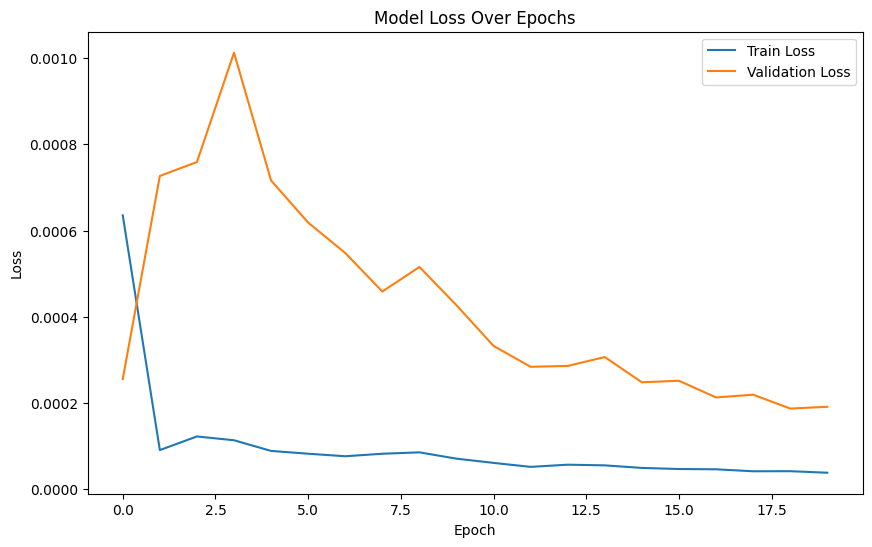

In [25]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam

# Assuming best_hps is already defined with the best hyperparameters
best_hps = {'units': 352, 'dropout': 0.0, 'learning_rate': .0006562536901904111}

model = Sequential()
model.add(SimpleRNN(best_hps.get('units'), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(best_hps.get('dropout')))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_hps.get('learning_rate')), loss='mean_squared_error')

# Training the model
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plotting the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [26]:
# Evaluate the model on the test set
test_loss = model.evaluate(test_X, test_y, verbose=2)
print(f'Test Loss: {test_loss}')



873/873 - 2s - loss: 1.9133e-04 - 2s/epoch - 3ms/step
Test Loss: 0.0001913328014779836


In [27]:
# Make predictions
predictions = model.predict(test_X)




873/873 [==============================] - 4s 4ms/step


In [28]:
import pandas as pd

# Extract the date portion that corresponds to your test dataset
# Assuming 'date_column' is your date column and its length matches the original dataset
test_dates = data['Date'][-len(test_y):]



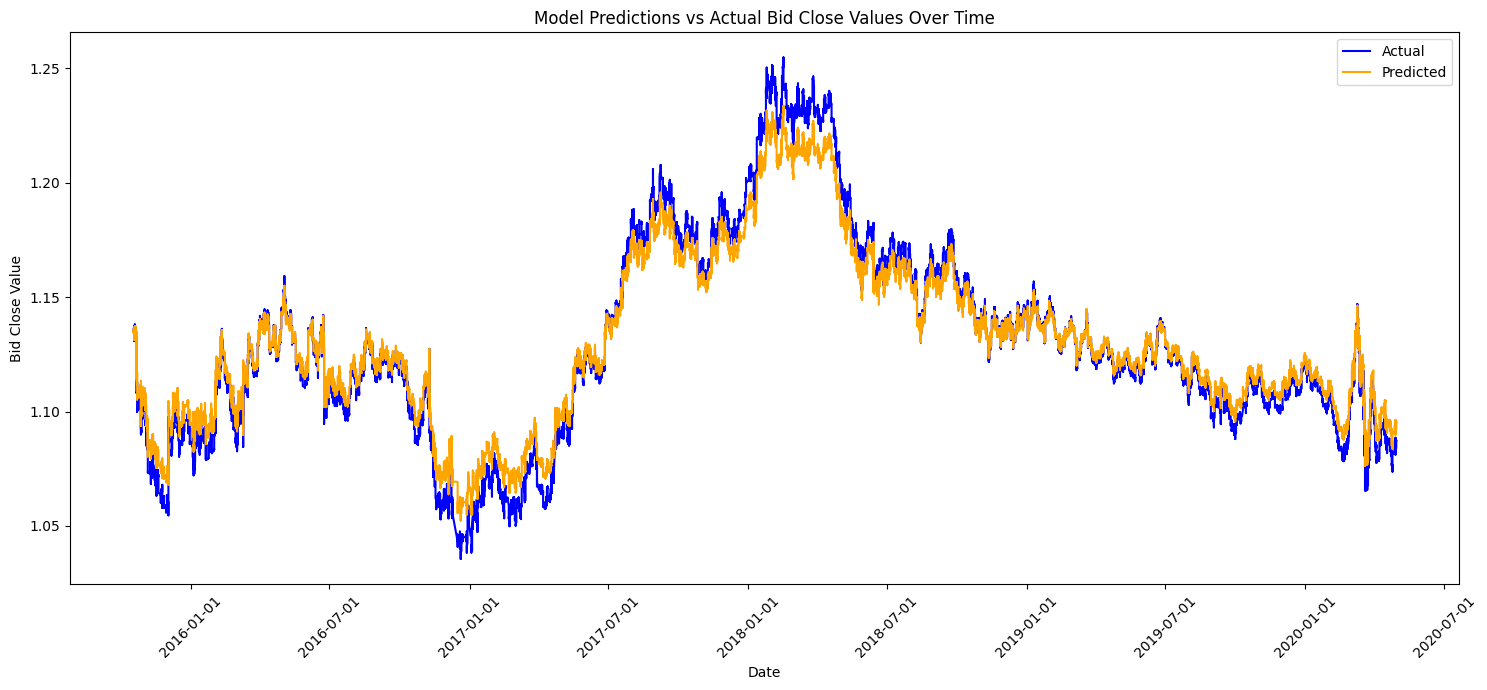

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import load_model

# Assuming that 'data' is your DataFrame after loading 'eurusd_hour.csv'
data = pd.read_csv('/content/drive/My Drive/archive-2/eurusd_hour.csv')

# Assuming that 'scaler' is your MinMaxScaler object and 'test_y' is the scaled test data
test_y_inverse = scaler.inverse_transform(test_y.reshape(-1, 1))

# Assuming that 'predictions' is the output from your model
predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1))



# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Assuming 'test_y' and 'predictions' are already scaled and reshaped correctly

# You need to extract the subset of dates that aligns with your test set
# The number of dates should match the number of test_y and prediction values
test_dates = data['Date'][-len(test_y):]

# Now, plot the actual bid close values and the predicted values against the dates
plt.figure(figsize=(15, 7))
plt.plot(test_dates, test_y_inverse.flatten(), label='Actual', color='blue')
plt.plot(test_dates, predictions_inverse.flatten(), label='Predicted', color='orange')

# Formatting the date to display in a more readable format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel('Date')
plt.ylabel('Bid Close Value')
plt.title('Model Predictions vs Actual Bid Close Values Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to fit better
plt.show()



In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and MSE
mae = mean_absolute_error(test_y_inverse, predictions_inverse)
mse = mean_squared_error(test_y_inverse, predictions_inverse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


Mean Absolute Error: 0.006194639441980756
Mean Squared Error: 6.125998257200036e-05


In [44]:

# Save the model
model.save('/content/drive/My Drive/my_lstm_model.h5')

# Save the scaler
import joblib
scaler_filename = "/content/drive/My Drive/my_lstm_scaler.save"
joblib.dump(scaler, scaler_filename)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['/content/drive/My Drive/my_lstm_scaler.save']

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step


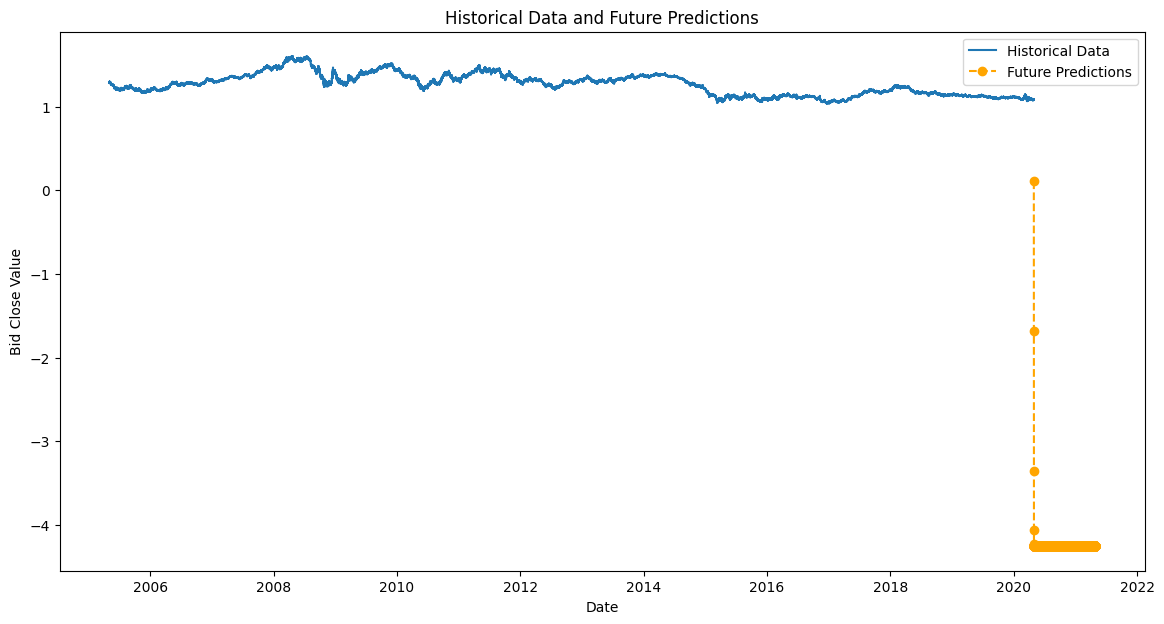

In [47]:

import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from keras.models import load_model

# Load the saved LSTM model
model = load_model('/content/drive/My Drive/my_lstm_model.h5')

# Load the saved scaler
scaler = joblib.load("/content/drive/My Drive/my_lstm_scaler.save")


# Assuming 'BC' is the column with the bid close values that you want to predict
# Extract the last known values of 'BC' that match the input shape of the model
last_known_data = data['BC'].values[-model.input_shape[1]:].reshape(-1, 1)

# Scale the last known data to prepare for prediction
last_known_data_scaled = scaler.transform(last_known_data)

# Now, proceed with creating the input for prediction
current_input = last_known_data_scaled.reshape(1, -1)

# Define the number of future steps you want to predict
n_future_steps = 24 * 365  # For example, predict the next 24 hours for 365 days

# Initialize the list for future predictions
future_predictions = []
# Ensure that the number of timesteps and features is set correctly
timesteps = model.input_shape[1]
features = 1  # Assuming you have one feature, such as 'BC'
# Assuming your trained model and last sequence are correctly defined

# Convert the last known sequence to the correct shape
current_input = last_known_data_scaled.reshape(1, -1, 1)

# Define the number of features (for example, 1 if 'BC' is the only feature used)
n_features = 1

for _ in range(n_future_steps):
    # Get the model's prediction for the next step
    next_step_prediction = model.predict(current_input)[0, 0]

    # Add the prediction to the list of future predictions
    future_predictions.append(next_step_prediction)

    # Update the input sequence to include the new prediction
    # This step involves reshaping the new prediction to match the input dimensions
    next_step_prediction_scaled = scaler.transform([[next_step_prediction]])
    next_step_prediction_scaled = next_step_prediction_scaled.reshape(1, 1, n_features)

    # Now, append the prediction to the current input for the next prediction
    current_input = np.append(current_input[:, 1:, :], next_step_prediction_scaled, axis=1)


# Now, future_predictions holds the scaled predictions for future steps.
# You would then inverse transform these predictions if needed and plot them as before.



# Generate the future dates corresponding to the future predictions
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=n_future_steps + 1, freq='H')[1:]

# Plot the historical and future data
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['BC'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='orange', linestyle='--', marker='o')
plt.xlabel('Date')
plt.ylabel('Bid Close Value')
plt.title('Historical Data and Future Predictions')
plt.legend()
plt.show()






